# Data Preparation Notebook — Overview

**Purpose:** Turn the *raw* CSV into a clean, modeling-ready dataset with clear, reproducible steps.

## What we’ll do
1. **Load RAW data** (notebook-relative path; URL fallback disabled here).
2. **Quick checks**: shape, schema, missing values, basic stats.
3. **Data quality**: duplicates, low-variance, outlier scan (z-score view only).
4. **Feature engineering**  
   - Split `Landfill Location (Lat, Long)` → `Latitude`, `Longitude`  
   - Drop ID-like columns: `Landfill Name`, raw `Lat, Long`  
   - Create helper features: `Utilization_Ratio`, `Cost_Efficiency`, `Campaign_Intensity`, `Waste_to_Density`  
   - Optional: `Density_Bin` (quartiles)
5. **Feature sets**: define `cat_cols` and `num_cols` for modeling.
6. **Sanity guards**: simple assertions (e.g., Recycling % in 0–100, Efficiency 1–10).
7. **Persist outputs**  
   - `data/processed/clean_waste_mgmt.csv`  
   - `data/processed/feature_config.json`  
   - Optional: `train.csv` / `test.csv` split

## Run order (cells)
- **3.0–3.9**: EDA quick checks (schema, stats, distribs, correlations)  
- **4.1–4.4**: Feature engineering & feature lists  
- **4.F–4.I**: Sanity checks + save processed + (optional) split

> **Artifacts saved:**  
> Clean CSV → `../data/processed/clean_waste_mgmt.csv`  
> Feature config → `../data/processed/feature_config.json`


# Step 1: Project Setup

We create a clean folder structure for our hackathon project:
- `data/raw` → original dataset
- `data/processed` → cleaned versions
- `src/` → preprocessing, training, inference scripts
- `Notebooks/` → EDA and experiments
- `models/` → saved ML models
- `static/` & `templates/` → Flask web app


# Step 2: Environment & Data Loading

We created a virtual environment, installed dependencies, and implemented a flexible data loader:
- Reads from relative path if available
- Falls back to absolute path
- If not found, fetches dataset from URL


In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

from src.data.preprocess import load_data

df = load_data()
print("Shape:", df.shape)
df.head(1)



[INFO] using relative path
Shape: (850, 13)


,City/District,Waste Type,Waste Generated (Tons/Day),Recycling Rate (%),Population Density (People/km²),Municipal Efficiency Score (1-10),Disposal Method,Cost of Waste Management (₹/Ton),Awareness Campaigns Count,Landfill Name,"Landfill Location (Lat, Long)",Landfill Capacity (Tons),Year
0,Mumbai,Plastic,6610,68,11191,9,Composting,3056,14,Mumbai Landfill,"22.4265, 77.4931",45575,2019


## Step 3 — Exploratory Data Analysis (EDA)
We’ll explore: shape/columns, missing values, descriptive stats, target distribution, and categorical spreads. Outputs after each cell will guide feature engineering.


In [2]:
import sys, os
sys.path.insert(0, os.path.abspath("../src"))

from data.preprocess import load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = load_data()
print("Shape:", df.shape)
df.head(3)


[INFO] using relative path
Shape: (850, 13)


,City/District,Waste Type,Waste Generated (Tons/Day),Recycling Rate (%),Population Density (People/km²),Municipal Efficiency Score (1-10),Disposal Method,Cost of Waste Management (₹/Ton),Awareness Campaigns Count,Landfill Name,"Landfill Location (Lat, Long)",Landfill Capacity (Tons),Year
0,Mumbai,Plastic,6610,68,11191,9,Composting,3056,14,Mumbai Landfill,"22.4265, 77.4931",45575,2019
1,Mumbai,Organic,1181,56,11191,5,Composting,2778,12,Mumbai Landfill,"22.4265, 77.4931",45575,2019
2,Mumbai,E-Waste,8162,53,11191,8,Incineration,3390,13,Mumbai Landfill,"22.4265, 77.4931",45575,2019



Loaded via **relative path**. **Shape:** (850, 13). Columns look correct; preview confirms parsing (e.g., City/District, Waste Type … Year).


### 3.1 — Schema & missing values


In [3]:
print("Shape:", df.shape)
df.info()
print("\nMissing per column:\n", df.isna().sum())


Shape: (850, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   City/District                      850 non-null    object
 1   Waste Type                         850 non-null    object
 2   Waste Generated (Tons/Day)         850 non-null    int64 
 3   Recycling Rate (%)                 850 non-null    int64 
 4   Population Density (People/km²)    850 non-null    int64 
 5   Municipal Efficiency Score (1-10)  850 non-null    int64 
 6   Disposal Method                    850 non-null    object
 7   Cost of Waste Management (₹/Ton)   850 non-null    int64 
 8   Awareness Campaigns Count          850 non-null    int64 
 9   Landfill Name                      850 non-null    object
 10  Landfill Location (Lat, Long)      850 non-null    object
 11  Landfill Capacity (Tons)           850 non-null    int


Shape: **850 × 13**. Types: **8 numeric**, **5 categorical**.  
Missing values: **0 in all columns** → data is clean; no imputation needed at EDA stage.


### 3.2 — Descriptive statistics


In [4]:
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
City/District,850,34,Mumbai,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Waste Type,850,5,Plastic,170,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Waste Generated (Tons/Day),850.0,NaN,NaN,NaN,5262.249412,2786.984735,511.0,2865.75,5283.0,7757.25,9980.0
Recycling Rate (%),850.0,NaN,NaN,NaN,57.076471,16.129994,30.0,43.0,56.0,71.0,85.0
Population Density (People/km²),850.0,NaN,NaN,NaN,13489.705882,6631.081494,2335.0,7927.0,12579.5,19087.0,24032.0
Municipal Efficiency Score (1-10),850.0,NaN,NaN,NaN,7.4,1.722162,5.0,6.0,7.0,9.0,10.0
Disposal Method,850,4,Incineration,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cost of Waste Management (₹/Ton),850.0,NaN,NaN,NaN,2778.458824,1276.32563,503.0,1647.5,2853.0,3855.0,4999.0
Awareness Campaigns Count,850.0,NaN,NaN,NaN,9.904706,6.070772,0.0,5.0,10.0,15.0,20.0
Landfill Name,850,34,Mumbai Landfill,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN



- **Recycling Rate (%)**: mean **57.1**, IQR **43–71**, range **30–85**.
- **Waste Generated (T/D)**: mean **5262**, wide spread **511–9980**.
- **Population Density**: mean **13,490**, wide spread **2,335–24,032**.
- **Efficiency Score (1–10)**: mean **7.4**, quartiles **6–9**.
- **Cost (₹/Ton)**: mean **2,778**, range **503–4,999**.
- **Campaigns**: mean **9.9**, range **0–20**.
- **Landfill Capacity**: mean **58,935**, range **22,690–98,646**.
- **Year**: 2019–2023 (centered around **2021**).


### 3.3 — Target distribution (Recycling Rate %)


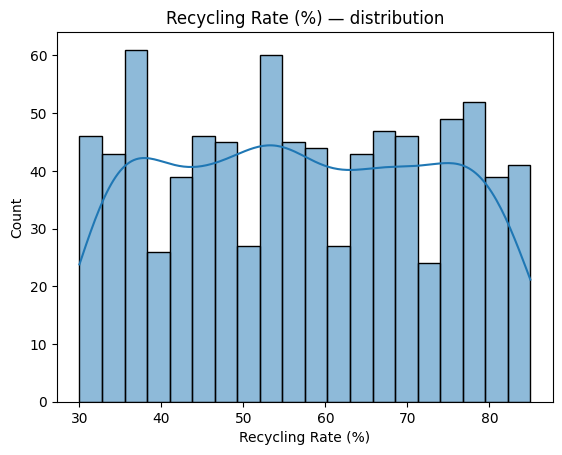

In [5]:
sns.histplot(df["Recycling Rate (%)"], bins=20, kde=True)
plt.title("Recycling Rate (%) — distribution")
plt.xlabel("Recycling Rate (%)"); plt.ylabel("Count")
plt.show()


`Recycling Rate (%)` ~30–85, mean ≈ 57. Spread healthy; no major skew or heavy tails.


### 3.4 — Categorical features overview


In [6]:
for col in ["City/District","Waste Type","Disposal Method"]:
    print(f"\n{col} → unique:", df[col].nunique())
    print(df[col].value_counts().head())



City/District → unique: 34
City/District
Mumbai       25
Delhi        25
Bengaluru    25
Chennai      25
Kolkata      25
Name: count, dtype: int64

Waste Type → unique: 5
Waste Type
Plastic         170
Organic         170
E-Waste         170
Construction    170
Hazardous       170
Name: count, dtype: int64

Disposal Method → unique: 4
Disposal Method
Incineration    218
Recycling       213
Landfill        210
Composting      209
Name: count, dtype: int64



- **City/District:** 34 uniques; counts are very balanced (e.g., Mumbai/Delhi/Bengaluru/Chennai/Kolkata all 25).  
- **Waste Type:** 5 categories, **exactly balanced** (170 each) → safe for OneHot.  
- **Disposal Method:** 4 categories, **near-uniform** (209–218) → no imbalance concerns.


### 3.5 — Duplicates & low-variance checks


In [7]:
dup_cnt = df.duplicated().sum()
low_var = [c for c in df.select_dtypes('number').columns if df[c].nunique()<=1]
{"duplicates": dup_cnt, "low_variance_numeric": low_var}


{'duplicates': np.int64(0), 'low_variance_numeric': []}


Duplicates: **0**. Low-variance numeric columns: **none**. → No rows to drop; all numeric features have variability.


### 3.6 — Outlier scan (|z|>3)


In [8]:
num_cols_all = df.select_dtypes('number').columns
z = (df[num_cols_all]-df[num_cols_all].mean())/df[num_cols_all].std(ddof=0)
(np.abs(z)>3).sum().sort_values(ascending=False)


Waste Generated (Tons/Day)           0
Recycling Rate (%)                   0
Population Density (People/km²)      0
Municipal Efficiency Score (1-10)    0
Cost of Waste Management (₹/Ton)     0
Awareness Campaigns Count            0
Landfill Capacity (Tons)             0
Year                                 0
dtype: int64

No |z|>3 outliers in numeric features.

### 3.7 — Avg target by category (top groups)


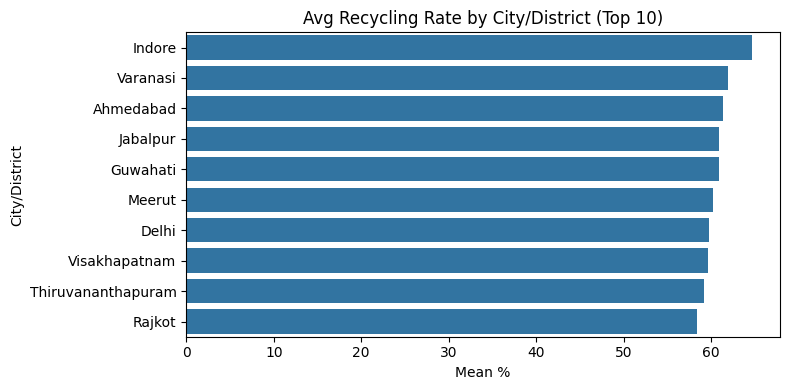

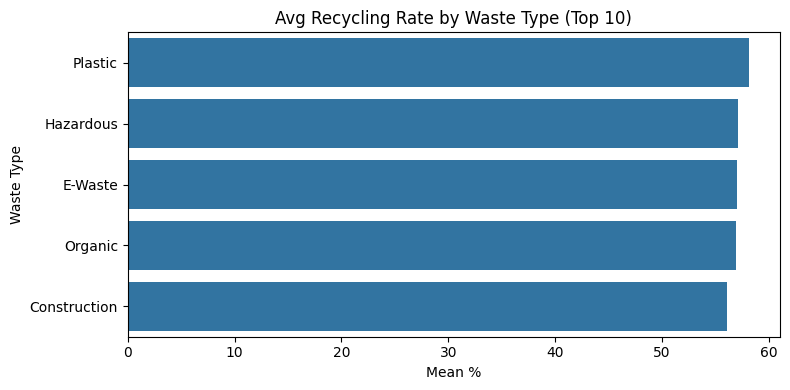

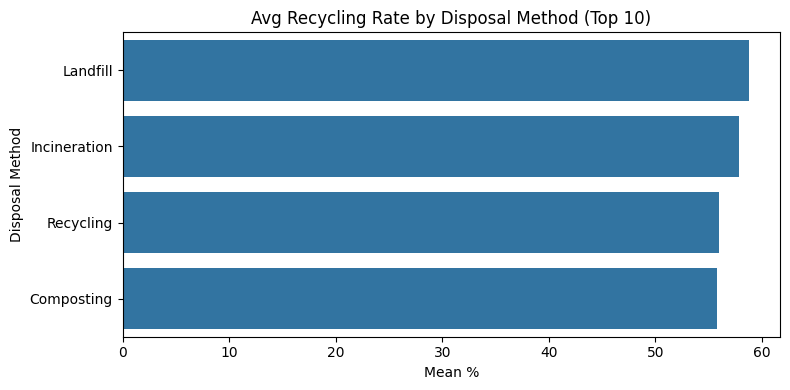

In [9]:
for c in ["City/District","Waste Type","Disposal Method"]:
    s = df.groupby(c)["Recycling Rate (%)"].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,4)); sns.barplot(x=s.values, y=s.index)
    plt.title(f"Avg Recycling Rate by {c} (Top 10)")
    plt.xlabel("Mean %"); plt.ylabel(c); plt.tight_layout(); plt.show()


- Top city: **Indore** (~64%), then **Varanasi, Ahmedabad, Jabalpur, Guwahati, Meerut, Delhi, Visakhapatnam, Thiruvananthapuram, Rajkot** (~59–63%).  
Spread ≈ **4–5 pts** → city effect **modest but real** → keep `City/District` as a categorical (OneHot).
- Plastic ≳ highest mean; Construction ≲ lowest. Spread small (~2–3 pts) → category effect mild but present.
- Landfill ≳ highest, then Incineration; Recycling/Composting slightly lower. Differences are modest.



### 3.8 — Yearly trend of target


Year
2019    55.429412
2020    57.976471
2021    56.988235
2022    57.682353
2023    57.305882
Name: Recycling Rate (%), dtype: float64


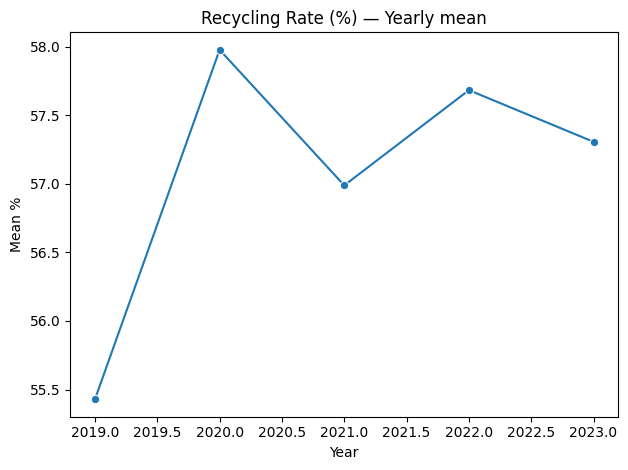

In [10]:
yr = df.groupby("Year")["Recycling Rate (%)"].mean()
print(yr)
sns.lineplot(x=yr.index, y=yr.values, marker="o")
plt.title("Recycling Rate (%) — Yearly mean"); plt.xlabel("Year"); plt.ylabel("Mean %")
plt.tight_layout(); plt.show()



Peak around 2020 (~58%), dip in 2021, slight rise 2022, small dip 2023. Overall near-flat → Year is a weak predictor.


### 3.9 — Correlation heatmap (numeric ↔ target)


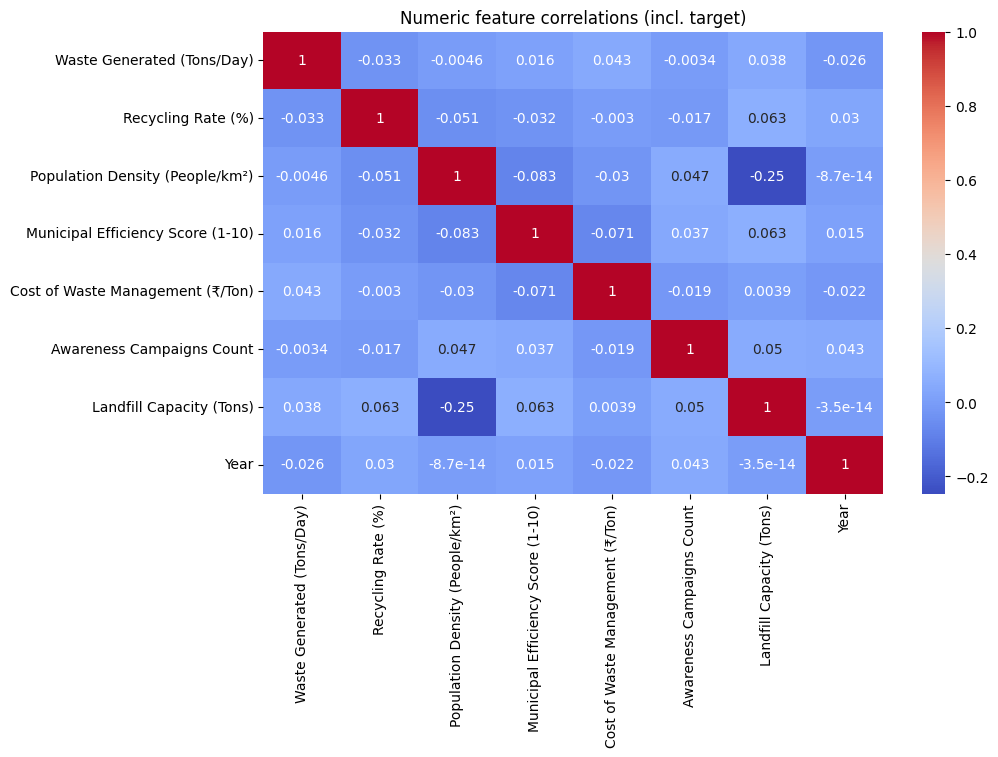

In [11]:
num_only = df.select_dtypes('number').columns.tolist()
plt.figure(figsize=(10,6))
sns.heatmap(df[num_only].corr(), annot=True, cmap="coolwarm")
plt.title("Numeric feature correlations (incl. target)")
plt.show()


All numeric ↔ target correlations are **very weak** (≈ −0.05 to +0.06). Slight +: Municipal Efficiency, Landfill Capacity. Slight −: Population Density. → Rely on categorical + nonlinear models (trees).


## Step 4 — Feature Engineering

**Goal:** prepare modeling-ready features without leakage.

**We will:**
- Split `Landfill Location (Lat, Long)` → `Latitude`, `Longitude` (float)
- Drop ID-like columns: `Landfill Name`, raw `Lat, Long`
- Create engineered features:
  - `Utilization_Ratio = Waste Generated / Landfill Capacity`
  - `Cost_Efficiency = Municipal Efficiency / (Cost ₹/Ton + 1)`
  - `Campaign_Intensity = Campaigns / (Population Density + 1)`
  - `Waste_to_Density = Waste Generated / (Population Density + 1)`
- (Optional) `Density_Bin` from Population Density (quartiles)
- Define `cat_cols` & `num_cols` for the model
- (Optional) quick re-correlation after new features

**Outputs to check:**
- Head (shows `Latitude`, `Longitude`)
- Summary of engineered columns
- `Density_Bin` value counts (if created)
- Printed lists: `Categorical:` …, `Numerical:` …


In [12]:
# Split lat/long and drop ID-like columns
latlon = df["Landfill Location (Lat, Long)"].str.split(",", expand=True)
df["Latitude"]  = latlon[0].astype(float)
df["Longitude"] = latlon[1].str.strip().astype(float)
df.drop(columns=["Landfill Name","Landfill Location (Lat, Long)"], inplace=True)

df.head(3)


,City/District,Waste Type,Waste Generated (Tons/Day),Recycling Rate (%),Population Density (People/km²),Municipal Efficiency Score (1-10),Disposal Method,Cost of Waste Management (₹/Ton),Awareness Campaigns Count,Landfill Capacity (Tons),Year,Latitude,Longitude
0,Mumbai,Plastic,6610,68,11191,9,Composting,3056,14,45575,2019,22.4265,77.4931
1,Mumbai,Organic,1181,56,11191,5,Composting,2778,12,45575,2019,22.4265,77.4931
2,Mumbai,E-Waste,8162,53,11191,8,Incineration,3390,13,45575,2019,22.4265,77.4931


Latitude/Longitude created; dropped: Landfill Name + raw Lat,Long. Head looks sane.


In [13]:
eps = 1e-6
df["Utilization_Ratio"] = df["Waste Generated (Tons/Day)"] / (df["Landfill Capacity (Tons)"] + eps)
df["Cost_Efficiency"]   = df["Municipal Efficiency Score (1-10)"] / (df["Cost of Waste Management (₹/Ton)"] + 1)
df["Campaign_Intensity"]= df["Awareness Campaigns Count"] / (df["Population Density (People/km²)"] + 1)
df["Waste_to_Density"]  = df["Waste Generated (Tons/Day)"] / (df["Population Density (People/km²)"] + 1)

df[["Utilization_Ratio","Cost_Efficiency","Campaign_Intensity","Waste_to_Density"]].describe().T


,count,mean,std,min,25%,50%,75%,max
Utilization_Ratio,850.0,0.101483,0.070404,0.005884,0.049931,0.090731,0.134391,0.422477
Cost_Efficiency,850.0,0.003738,0.003002,0.001004,0.001851,0.002655,0.004546,0.019841
Campaign_Intensity,850.0,0.001087,0.001266,0.000000,0.000346,0.000745,0.001261,0.008562
Waste_to_Density,850.0,0.605284,0.695275,0.025008,0.202544,0.389892,0.668782,4.270548



Engineered stats — Utilization_Ratio≈0.10 (±0.07), Cost_Efficiency≈0.0037, Campaign_Intensity≈0.0011, Waste_to_Density≈0.61.


In [14]:
import pandas as pd
try:
    df["Density_Bin"] = pd.qcut(
        df["Population Density (People/km²)"], q=4,
        labels=["Low","Mid-Low","Mid-High","High"], duplicates="drop"
    )
except Exception as e:
    print("qcut warning:", e)
    df["Density_Bin"] = pd.cut(
        df["Population Density (People/km²)"], bins=4,
        labels=["Low","Mid-Low","Mid-High","High"]
    )
df["Density_Bin"].value_counts()


Density_Bin
Low         225
Mid-High    225
Mid-Low     200
High        200
Name: count, dtype: int64


Density_Bin counts: Low 225, Mid-Low 200, Mid-High 225, High 200.


In [15]:
target_col = "Recycling Rate (%)"
cat_cols = ["City/District","Waste Type","Disposal Method"] + (["Density_Bin"] if "Density_Bin" in df.columns else [])
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]

print("Categorical:", cat_cols)
print("Numerical:", num_cols)


Categorical: ['City/District', 'Waste Type', 'Disposal Method', 'Density_Bin']
Numerical: ['Waste Generated (Tons/Day)', 'Population Density (People/km²)', 'Municipal Efficiency Score (1-10)', 'Cost of Waste Management (₹/Ton)', 'Awareness Campaigns Count', 'Landfill Capacity (Tons)', 'Year', 'Latitude', 'Longitude', 'Utilization_Ratio', 'Cost_Efficiency', 'Campaign_Intensity', 'Waste_to_Density']


Categorical: City/District, Waste Type, Disposal Method, Density_Bin.  
Numerical: 13 cols incl. Year, Lat/Lon + engineered features.


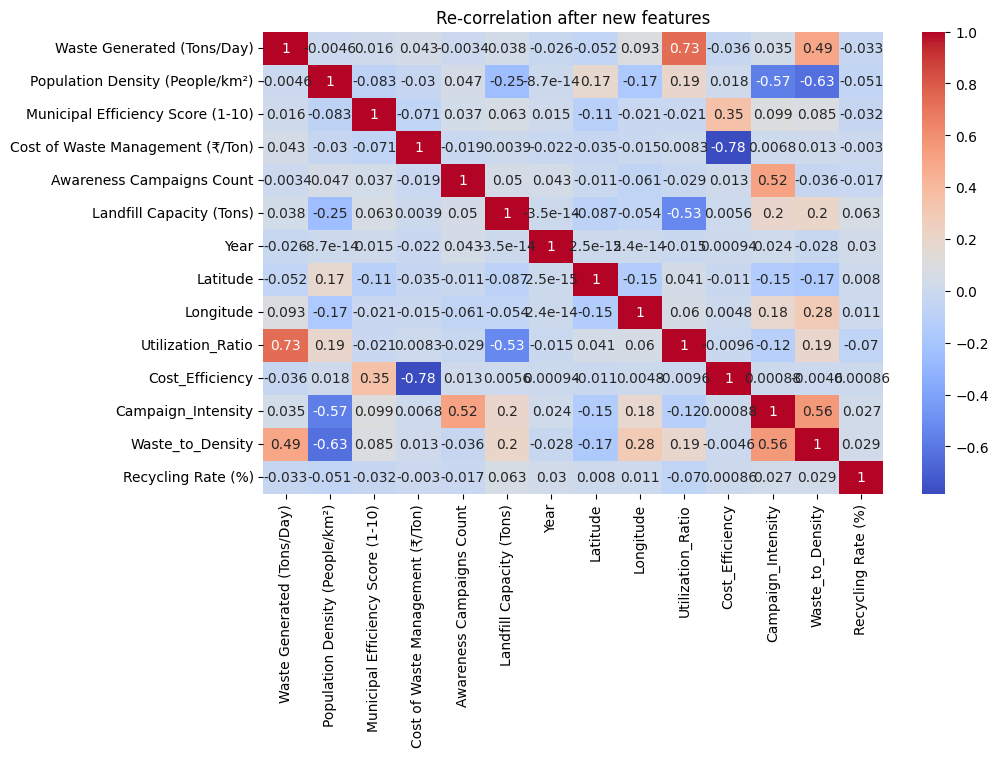

In [16]:
# (optional) quick re-correlation
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols + [target_col]].corr(), annot=True, cmap="coolwarm")
plt.title("Re-correlation after new features"); plt.show()


Target correlations remain very weak (<≈0.1). New features add mild signal; trees + OneHot should work best.


In [18]:
# simple data-quality guards (safe to re-run)
assert df["Recycling Rate (%)"].between(0,100).all()
assert df["Municipal Efficiency Score (1-10)"].between(1,10).all()
nonneg = ["Waste Generated (Tons/Day)","Population Density (People/km²)",
          "Cost of Waste Management (₹/Ton)","Awareness Campaigns Count",
          "Landfill Capacity (Tons)","Year"]
for c in nonneg: assert (df[c] >= 0).all()
print("✅ basic sanity checks passed")


✅ basic sanity checks passed


In [19]:
import os, json
os.makedirs("../data/processed", exist_ok=True)

# full processed
df.to_csv("../data/processed/clean_waste_mgmt.csv", index=False)
# (optional fast IO)
try:
    df.to_parquet("../data/processed/clean_waste_mgmt.parquet", index=False)
except Exception as e:
    print("parquet skip:", e)

print("✅ saved -> data/processed/")


✅ saved -> data/processed/


In [20]:
cfg = {
    "target": "Recycling Rate (%)",
    "categorical": ["City/District","Waste Type","Disposal Method"] + (["Density_Bin"] if "Density_Bin" in df.columns else []),
    "numerical": [c for c in df.columns if c not in ["Recycling Rate (%)","City/District","Waste Type","Disposal Method","Density_Bin"]]
}
with open("../data/processed/feature_config.json","w") as f:
    json.dump(cfg, f, indent=2)
print("✅ saved -> data/processed/feature_config.json")


✅ saved -> data/processed/feature_config.json


In [21]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Waste Type"])
train_df.to_csv("../data/processed/train.csv", index=False)
test_df.to_csv("../data/processed/test.csv", index=False)
print("✅ saved -> train.csv / test.csv")


✅ saved -> train.csv / test.csv
